# Image Classification base code

이 파일은 boostcamp AI Tech에서 제공하는 **sample_submission.ipynb **과 이민준 캠퍼님의 **resnet18 base code**를 참고하여 직상헸습니다.

### 0. Libarary 불러오기 및 경로설정

In [1]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize

In [2]:
# 훈련 데이터셋 폴더 경로 지정
train_dir = '/opt/ml/input/data/train'
train_img_dir_path = os.path.join(train_dir, 'images')
train_img_dir_path

'/opt/ml/input/data/train/images'

In [3]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [4]:
train_df = pd.read_csv('./input/data/train/train.csv')
train_df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


### 1. Dataset 정의

In [5]:
# dir_name 디렉토리 하부에 있는 모든 파일을 검색합니다. 
def search(dir_name, result):
    try:
        filenames = os.listdir(dir_name)
        for fname in filenames:
            if fname[0] == '.' : # .으로 시작하는 파일명을 제외함 (ex: ._00~~~ 파일 제외)
                continue
            filename = os.path.join(dir_name, fname) # 폴더명, 파일명 
            if os.path.isdir(filename): # 디렉토리 여부 확인
                search(filename, result) # 하부 파일 목록 추출 (incorrect, mask, normal)
            else:
                ext = os.path.splitext(filename)[-1] # splitext()[-1] : 확장자 찾기 
                if ext:
                    result.append(filename) # 확장자 추가
                # if ext != '.jpg':
                #     print(ext)
    except PermissionError: 
        print("파일의 경로 설정을 확인해보세요.")
        pass

In [6]:
all_path = []
search(train_img_dir_path, all_path)
all_path

['/opt/ml/input/data/train/images/005522_female_Asian_55/mask3.jpg',
 '/opt/ml/input/data/train/images/005522_female_Asian_55/mask2.jpg',
 '/opt/ml/input/data/train/images/005522_female_Asian_55/mask4.jpg',
 '/opt/ml/input/data/train/images/005522_female_Asian_55/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/005522_female_Asian_55/normal.jpg',
 '/opt/ml/input/data/train/images/005522_female_Asian_55/mask5.jpg',
 '/opt/ml/input/data/train/images/005522_female_Asian_55/mask1.jpg',
 '/opt/ml/input/data/train/images/000268_male_Asian_59/mask3.jpg',
 '/opt/ml/input/data/train/images/000268_male_Asian_59/mask2.jpg',
 '/opt/ml/input/data/train/images/000268_male_Asian_59/mask4.jpg',
 '/opt/ml/input/data/train/images/000268_male_Asian_59/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/000268_male_Asian_59/normal.jpg',
 '/opt/ml/input/data/train/images/000268_male_Asian_59/mask5.jpg',
 '/opt/ml/input/data/train/images/000268_male_Asian_59/mask1.jpg',
 '/opt/ml/input/data/train/i

In [7]:
all_path = sorted(all_path) # 파일을 sorting 해줍니다. 

len(all_path)
all_path

['/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask1.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask2.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask3.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask4.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask5.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/normal.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask1.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask2.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask3.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask4.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask5.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/normal.jpg',
 '/opt/ml/inpu

isdir과 listdir로 검색한 파일은 총 18900 개입니다.

2700 개의 image 폴더는 각각 7개의 파일(normal, incorrect, mask1~5)로 구성되어있습니다.

In [8]:
all_path[:10]

['/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask1.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask2.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask3.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask4.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask5.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/normal.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask1.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask2.jpg']

In [9]:
# 파일 확장자 확인
exts = []
for filepath in all_path:
    ext = os.path.splitext(filepath)[-1]
    if ext not in exts:
        exts.append(ext)
print(exts)

['.jpg', '.png', '.jpeg']


파일명을 분석하여 조건에 따라 class label list(정답)을 생성합니다.

- class 0 : mask, male, age <30
- class 1 : mask, male, 30 <= age < 60
- class 2 : mask, male, 60 <= age
- class 4 : mask, female, age <30
- class 5 : mask, female, 30 <= age < 60
- class 6 : mask, female, 60 <= age
- class 7 : incorrect, male, age <30
- class 8 : incorrect, male, 30 <= age < 60
- class 9 : incorrect, male, 60 <= age
- class 10 : incorrect, female, age <30
- class 11 : incorrect, female, 30 <= age < 60
- class 12 : incorrect, female, 60 <= age
- class 13 : normal, male, age <30
- class 14 : normal, male, 30 <= age < 60
- class 15 : normal, male, 60 <= age
- class 16 : normal, female, age <30
- class 17 : normal, female, 30 <= age < 60
- class 18 : normal, female, 60 <= age

In [10]:
# labeling : 조건에 따라 label에 숫자를 더해줍니다.
def labeling(name):
    label = 0
    info, mask_type = name.split('/')[-2:] # info = 'image 폴더명', mask_type = '파일명'
    info = info.split('_') # info = [index, gender, race, age]
    gender, age = info[1], int(info[3])
    if 'incorrect' in mask_type:
        label += 6
    elif 'normal' in mask_type:
        label += 12

    if gender == 'female':
        label += 3
    
    if 30 <= age < 60:
        label += 1
    elif age >= 60:
        label += 2
        
    return label

In [11]:
train_path_label = pd.DataFrame(all_path, columns = ['path'])

train_path_label['label'] = train_path_label['path'].map(lambda x : labeling(x))
train_path_label

,path,label
0,/opt/ml/input/data/train/images/000001_female_...,10
1,/opt/ml/input/data/train/images/000001_female_...,4
2,/opt/ml/input/data/train/images/000001_female_...,4
3,/opt/ml/input/data/train/images/000001_female_...,4
4,/opt/ml/input/data/train/images/000001_female_...,4
...,...,...
18895,/opt/ml/input/data/train/images/006959_male_As...,0
18896,/opt/ml/input/data/train/images/006959_male_As...,0
18897,/opt/ml/input/data/train/images/006959_male_As...,0
18898,/opt/ml/input/data/train/images/006959_male_As...,0


ytorch 에서는 데이터셋을 좀 더 쉽게 쉽게 다룰 수 있도록 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 

이 torch.utils.data.Dataset을 상속받아 직접 Custom DataSet을 만들어서 사용하는 경우도 많습니다. (reference : https://wikidocs.net/57165)

In [12]:
# dataset을 상속받아 만든 CustomDataset 입니다. 
class CustomDataset(Dataset):
    def __init__(self, img_paths_label, transform):
        self.X = img_paths_label['path']
        self.y = img_paths_label['label']
        self.transform = transform
    def __getitem__(self, index):
        image = Image.open(self.X.iloc[index])
        label = self.y.iloc[index]

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

    def __len__(self):
        return len(self.X)

In [13]:
# torchvision에서 제공해주는 다양한 함수를 이용하여 입력 영상을 전처리합니다.
# [512, 384] 크기로 영상을 resize하고 데이터를 Tensor로 만들어줍니다.
# 이후 정규화를 해줍니다. ([0,255]->[0, 1]로 표현합니다.  )
transform  = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

train data와 validation data를 구분합니다.

label의 비율을 유지하면서 분할합니다.

train data : 15120 (80%)

validation data : 3780 (20%)

In [14]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_path_label, test_size = 0.2, 
                                shuffle = True, stratify = train_path_label['label'],
                                random_state = 34 )

In [15]:
# Batch size 는 64로 설정하고, shuffle을 하여 DataLoader를 정의했습니다.
BATCH_SIZE = 64

train_dataset = CustomDataset(train, transform)

train_dataloader = DataLoader(train_dataset, 
                            batch_size=BATCH_SIZE,
                            shuffle=True
                            )

In [16]:
valid_dataset = CustomDataset(valid, transform)

valid_dataloader = DataLoader(valid_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = True
                            )

In [17]:
# dataloader는 [batchsize, channel, height, wide] 를 출력합니다. 
next(iter(train_dataloader))[0].shape

torch.Size([64, 3, 512, 384])

### 2. Model 정의

In [19]:
resnet18 = torchvision.models.resnet18(pretrained = True)

In [20]:
import math

OUTPUT_CLASS_NUM = 18
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = OUTPUT_CLASS_NUM, bias = True) 

# xavier uniform : 이전 노드와 다음 노드의 개수에 의존하는 초기화 방법으로 uniform/normal initialization의 두 가지 유형이 있습니다.
torch.nn.init.xavier_uniform_(resnet18.fc.weight)
stdv = 1. / math.sqrt(resnet18.fc.weight.size(1))
resnet18.fc.bias.data.uniform_(-stdv, stdv)

resnet18.fc.weight.shape[0]

18

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
device

device(type='cuda', index=0)

In [22]:
resnet18.to(device)

LEARNING_RATE = 0.0001 # 학습에서 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 20# 학습에서 데이터셋을 얼마나 많이 학습할 지 반복 횟수를 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습에서 많이 사용하는 Cross Entropy loss를 objective functionh으로 사용
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LEARNING_RATE) # weight updqte를 위한 optimizer를 Adam으로 설정

dataloaders = {
    "train" : train_dataloader,
    "test" : valid_dataloader
}

### 3. Inference

In [25]:
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in tqdm(range(NUM_EPOCH)):
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        if phase == "train":
            resnet18.train() # 네트워크 모델을 train 모드로 두어 gradient를 계산하고 여러 sub module (배치 정규화, 드롭아웃 등 )이 train mode로 작동할 수 있도록 함
        elif phase == "test":
            resnet18.eval() # 네트워크 모델을 eval 모드로 부여하여 여러 sub module들이 eval mode로 작동할 수 있도록 설정 

        for ind, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화 함

            with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient 를 계산하고, 
                                                           # 아닌 경우에는 gradient를 계산하지 않아 연산량이 최소화
                logits = resnet18(images)
                _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값을 최대 output index를 찾아 label([2])로 변경함
                loss = loss_fn(logits, labels)

                if phase == "train":
                    loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                    optimizer.step() # 계산된 gradient 를 가지고 모델 업데이트

            running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장
            
        # 한 EPOCH이 모두 종료되었을 때
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)

        print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss: .3f}, 평균 Accuracy : {epoch_acc: .3f}")
        if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
            best_test_accuracy = epoch_acc
        if phase == "test" and best_test_loss > epoch_loss : # phase가 test일 때 test loss 계산
            best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss: {best_test_loss}")

현재 epoch-0의 train-데이터 셋에서 평균 Loss :  0.489, 평균 Accuracy :  0.856
현재 epoch-0의 test-데이터 셋에서 평균 Loss :  0.195, 평균 Accuracy :  0.939
현재 epoch-1의 train-데이터 셋에서 평균 Loss :  0.076, 평균 Accuracy :  0.980
현재 epoch-1의 test-데이터 셋에서 평균 Loss :  0.109, 평균 Accuracy :  0.965
현재 epoch-2의 train-데이터 셋에서 평균 Loss :  0.019, 평균 Accuracy :  0.998
현재 epoch-2의 test-데이터 셋에서 평균 Loss :  0.058, 평균 Accuracy :  0.983
현재 epoch-3의 train-데이터 셋에서 평균 Loss :  0.006, 평균 Accuracy :  1.000
현재 epoch-3의 test-데이터 셋에서 평균 Loss :  0.039, 평균 Accuracy :  0.989
현재 epoch-4의 train-데이터 셋에서 평균 Loss :  0.006, 평균 Accuracy :  1.000
현재 epoch-4의 test-데이터 셋에서 평균 Loss :  0.039, 평균 Accuracy :  0.989
현재 epoch-5의 train-데이터 셋에서 평균 Loss :  0.003, 평균 Accuracy :  1.000
현재 epoch-5의 test-데이터 셋에서 평균 Loss :  0.081, 평균 Accuracy :  0.973
현재 epoch-6의 train-데이터 셋에서 평균 Loss :  0.025, 평균 Accuracy :  0.993
현재 epoch-6의 test-데이터 셋에서 평균 Loss :  0.114, 평균 Accuracy :  0.966
현재 epoch-7의 train-데이터 셋에서 평균 Loss :  0.032, 평균 Accuracy :  0.991
현재 epoch-7의 test-데이터 셋에서 평균 Loss

### 4. Evaluation

In [26]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0, 0
        model.eval()
        for batch_in, batch_out in data_iter :
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.to(device))
            _, y_pred = torch.max(model_pred, 1) # 행으로 비교
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct / n_total)
    return val_accr

In [27]:
func_eval(resnet18, valid_dataloader, device)

0.9936507936507937

In [28]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        model.eval()
        for i, (X,y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred,1)

            result.append([valid.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns=['path', 'pred', 'target'])
    return result

In [29]:
valid_testing_dataloader = DataLoader(valid_dataset, shuffle = False)

check_eval_df = check_eval(valid, valid_testing_dataloader, resnet18, device)
check_eval_df

,path,pred,target
0,/opt/ml/input/data/train/images/003403_male_As...,1,1
1,/opt/ml/input/data/train/images/000735_female_...,4,4
2,/opt/ml/input/data/train/images/006365_male_As...,6,6
3,/opt/ml/input/data/train/images/003434_male_As...,1,1
4,/opt/ml/input/data/train/images/001603_male_As...,0,0
...,...,...,...
3775,/opt/ml/input/data/train/images/004321_female_...,16,16
3776,/opt/ml/input/data/train/images/004088_female_...,5,5
3777,/opt/ml/input/data/train/images/001490_female_...,4,4
3778,/opt/ml/input/data/train/images/005026_male_As...,2,2


In [30]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop = True)
wrong_df

,path,pred,target
0,/opt/ml/input/data/train/images/004219_male_As...,13,14
1,/opt/ml/input/data/train/images/000685_male_As...,7,6
2,/opt/ml/input/data/train/images/003224_female_...,3,9
3,/opt/ml/input/data/train/images/004319-1_femal...,17,16
4,/opt/ml/input/data/train/images/005459_male_As...,13,14
5,/opt/ml/input/data/train/images/001751_male_As...,4,1
6,/opt/ml/input/data/train/images/003032_female_...,16,15
7,/opt/ml/input/data/train/images/005033_male_As...,7,8
8,/opt/ml/input/data/train/images/001235_male_As...,6,0
9,/opt/ml/input/data/train/images/005446_female_...,4,5


In [31]:

def draw_(df):
    plt.figure(figsize = (15, 30))
    row = 7
    for i in range(df.shape[0]):
        plt.subplot(row + 1, df.shape[0] // row, i+1)
        plt.imshow(Image.open(df['path'][i]))
        plt.title(f"target:{df['target'][i]}, pred:{df['pred'][i]}", color = 'r', size = 15)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

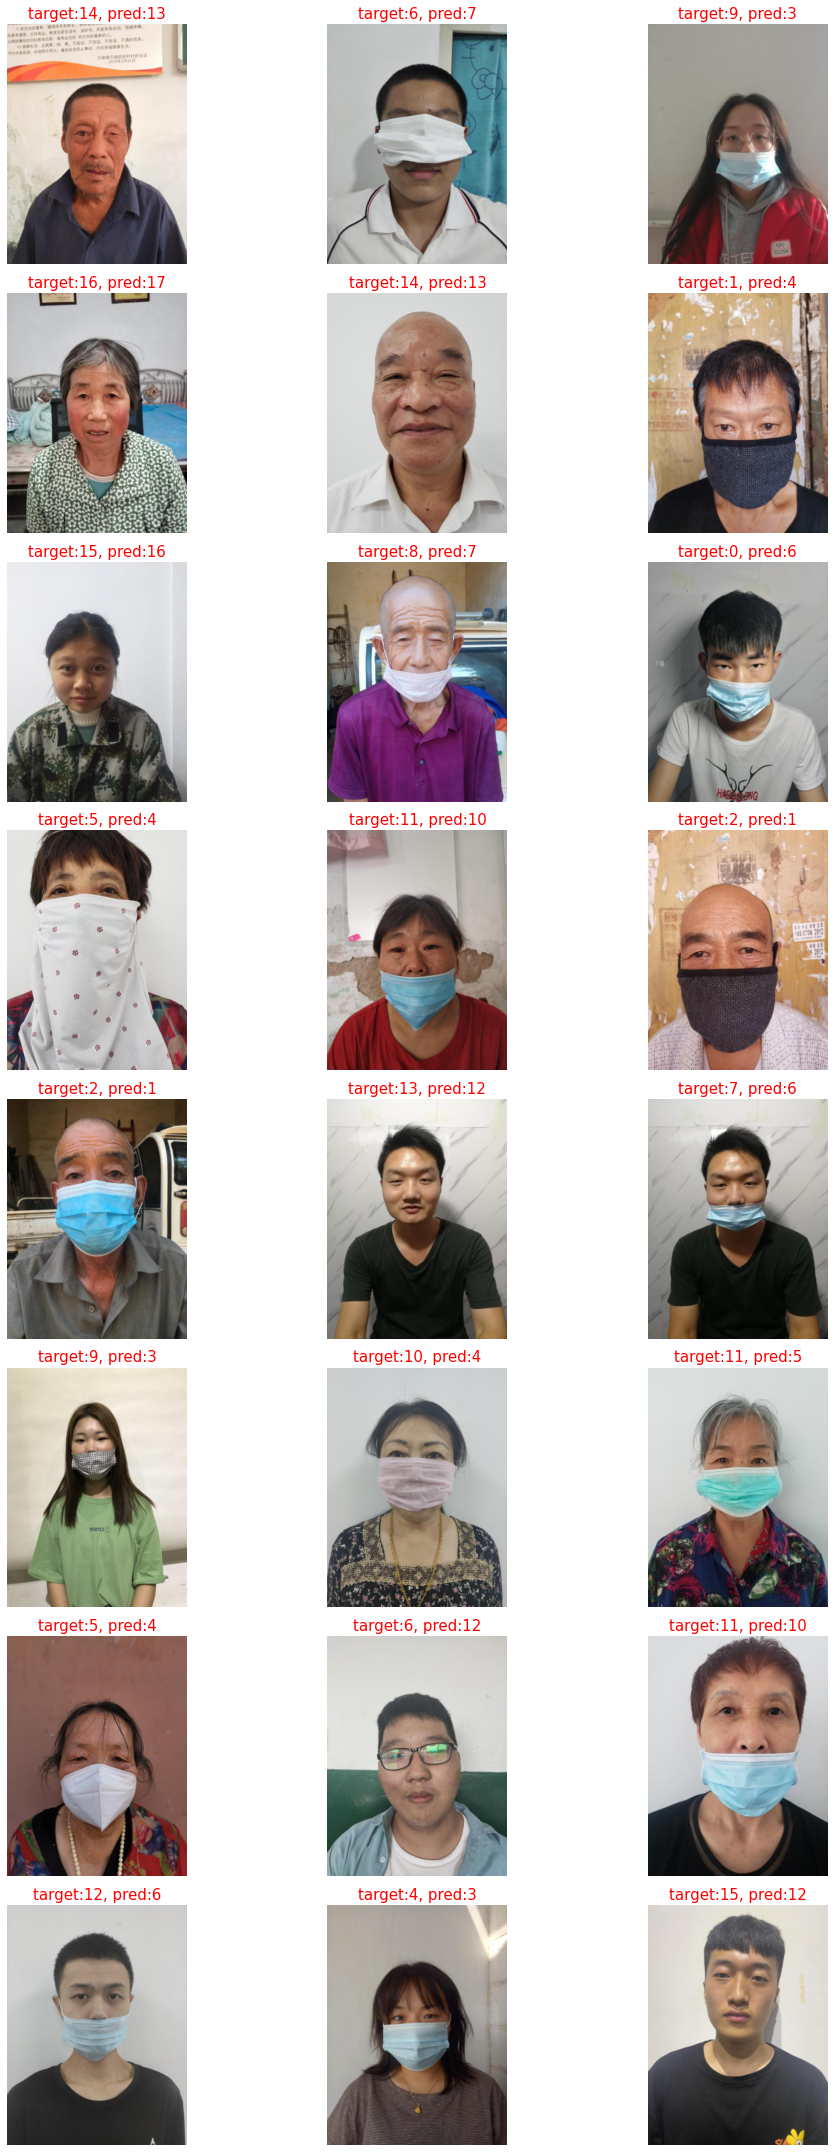

In [32]:
draw_(wrong_df)

### 5.Submit submission file

In [34]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

In [35]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [36]:
# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

test_dataset = TestDataset(image_paths, transform)

test_dataloader = DataLoader(test_dataset,
                            shuffle = False)

In [37]:
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.

def test(test_dataloader, model, device):
    all_predictions = []
    model.eval()
    
    for images in test_dataloader:
        with torch.no_grad():
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            all_predictions.extend(pred.cpu().numpy())
    submission['ans'] = all_predictions

    return submission

In [38]:
# 제출할 파일을 저장합니다.

submission = test(test_dataloader, resnet18, device)

submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
